# COMP90051 Project 2

In [6]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [7]:
############### Student ID: 941371, username: Ruizhil1############################

test_data = np.loadtxt('dataset.txt',dtype=np.int16)

## Read the test data from local file
##  Split data into different cases
arms = test_data[:,0]
rewards = test_data[:,1]
contexts = test_data[:,2:]

## 1. Implementing ε-Greedy and UCB

In [9]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [10]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # Initialise some useful instants
        # arm number
        self.narms = narms
        
        # explore probability
        self.epsilon = epsilon
        
        # initial value of Q for arms
        self.Q0 = Q0
        
        # total reward for each arms 
        self.total_reward = np.zeros(narms)
        
        # how much round we have run
        self.round = np.zeros(narms)
        
        # My estimate Q value for each arm 
        self.estimate_Q = [Q0 for i in range(narms)]
        
    def play(self, tround, context=None):
        # using np.random.rand to simulate the probability of explore
        # np.random.rand  return a float number ranges from [0,1)
        simulation = np.random.rand()
        if (simulation <= self.epsilon):
            return np.random.randint(1,self.narms+1)
        else:
            ### get the arm index with max Q value 
            # and then randomly choose one as the arm played
            max_Q = np.max(self.estimate_Q)
            arm_index_max_Q = [i+1 for i in range(self.narms) if self.estimate_Q[i] == max_Q]
            return np.random.choice(arm_index_max_Q)
        
    def update(self, arm, reward, context=None):
        # update reward, round and finally calculate the Q value
        self.total_reward[arm-1] = self.total_reward[arm-1]+reward
        self.round[arm-1] = self.round[arm-1]+1
        self.estimate_Q[arm-1] = self.total_reward[arm-1]/self.round[arm-1] 
        
    

In [21]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        
        # initial value of Q for arms
        self.Q0 = Q0
        
        # total reward for each arms 
        self.total_reward = np.zeros(narms)
        
        # how much round we have run
        self.round = np.zeros(narms)
        
        # My estimate Q value for each arm 
        self.estimate_Q = [Q0 for i in range(narms)]
    
    def play(self, tround, context=None):
        ### get the arm index with max Q value 
        # and then randomly choose one as the arm played
        max_Q = np.max(self.estimate_Q)
        arm_index_max_Q = [i+1 for i in range(self.narms) if self.estimate_Q[i] == max_Q]
        return np.random.choice(arm_index_max_Q)
    
    def update(self, arm, reward, context=None):
        # update reward, round and finally calculate the Q value
        self.total_reward[arm-1] = self.total_reward[arm-1]+reward
        self.round[arm-1] = self.round[arm-1]+1
        # the change is that we add explore boost when we calculating the Q value, compared with the e-greedy
        explore_boost = np.sqrt(self.rho*np.log(sum(self.round))/self.round[arm-1])   
        self.estimate_Q[arm-1] = self.total_reward[arm-1]/self.round[arm-1]+ explore_boost
        
    

## 2. The Basic Thompson Bandit

In [31]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms = narms
        self.alpha0 = alpha0
        self.beta0 = beta0
        
        # total reward for each arms 
        self.total_reward = np.zeros(narms)
        
        # how much round we have run
        self.round = np.zeros(narms)
        
        # Beta distribution, initialised for each arm
        self.beta_distribution = [[self.alpha0,self.beta0] for i in range(narms)]
        
    def play(self, tround, context=None):
        # Using Thompson Sampling here
        # random.beta() is for getting the beta distribution over [0,1] here, which means the probability.
        # random.beta() using the parameters stored in self.distribution
        # and then randomly choose one as the arm played from the maximum probability list 
        
        prob = [np.random.beta(item[0],item[1]) for item in self.beta_distribution]
        max_prob = np.max(prob)
        arm_index_max_prob = [i+1 for i in range(self.narms) if prob[i]==max_prob]
        return np.random.choice(arm_index_max_prob)    
        
    def update(self, arm, reward, context=None):
        # update reward, round and finally updated the alpha and beta parameters for the chosen arm. 
        self.total_reward[arm-1] = self.total_reward[arm-1]+reward
        self.round[arm-1] = self.round[arm-1]+1
        if reward == 1:
            self.beta_distribution[arm-1][0] = self.beta_distribution[arm-1][0] +1
        else:
            self.beta_distribution[arm-1][1] = self.beta_distribution[arm-1][1] +1
        

## 3. Off-Policy Evaluation

In [42]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    """Description from the paper:
     If, given the current history ht−1, 
     it happens that the policy π chooses the same arm a as the one that was selected by the logging policy, 
     then the event is retained, that is, added to the history,
     and the total payoff Rt updated. Otherwise, 
     if the policy π selects a different arm from the one that was taken by the logging policy, 
     then the event is entirely ignored, 
     and the algorithm proceeds to the next event without any other change in its state. 
    """
    tround = 0
    total_rewards = []
    # So, here I loop the arms
    for i in range(len(arms)):
        
        # I have played enough rounds, jump out
        if(tround == nrounds):
            break
        
        # if the selected arm matching the data I've choose 
        # then update the rewards and record the total reward in this round
        # also record the round I have played
        if (mab.play(tround,contexts[i])==arms[i]):
            tround = tround+1
            mab.update(arms[i],rewards[i],contexts[i])
            total_rewards.append(rewards[i])
            
    #print(len(total_rewards))
    return total_rewards
    

In [54]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.25625


In [62]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16625


In [48]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2025


## 4. Contextual Bandits - LinUCB

In [194]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        # parameter initialisation
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        
        # Three matrix described in the paper,
        # and A, b, A 's inversre matrix
        # For each arm, it will have its own matrix
        self.A_matrix = np.zeros((narms,ndims,ndims))
        self.b_matrix = np.zeros((narms,ndims,1))
        self.A_matrix_inverse = np.zeros((narms,ndims,ndims))
        
        # Initialise Matrix A and it's reverse Matrix
        for i in range(narms):
            self.A_matrix[i] = np.identity(ndims)
            self.A_matrix_inverse[i] = np.identity(ndims)
        
    def play(self, tround, context):
        
        p_result = []
        for i in range(self.narms):
            
            #get the corresponding context for this arm
            my_context_matrix = np.array([context[(i*10):(i*10+10)]])
            
            #  matrixθa, calculate the estimate_coefficient
            estimate_coefficient = np.mat(self.A_matrix_inverse[i]) * np.mat(self.b_matrix[i])
            #print(my_context_matrix.transpose())
            
            # calculate the standard deviation * alpha
            standard_deviation = self.alpha * np.sqrt(np.mat(my_context_matrix)*np.mat(self.A_matrix_inverse[i])*np.mat(my_context_matrix.transpose()))
            
            # get the distribution probability for this arm and add it to the list
            p_dist = np.mat(estimate_coefficient.transpose()) * np.mat(my_context_matrix.transpose())+ standard_deviation
            p_result.append(p_dist)
            
            
        # select the arm with max p distribution
        # with tie broken arbitrarily
        max_p_dist = np.max(p_result)
        arm_max_p_dist = [i+1 for i in range(self.narms) if p_result[i]==max_p_dist]
        return np.random.choice(arm_max_p_dist)
    
    def update(self, arm, reward, context):
        
        # get the context for this arm
        my_context_matrix = np.array([context[((arm-1)*10):((arm-1)*10+10)]])
        
        # update A matrix and b matrix
        self.A_matrix[arm-1] = self.A_matrix[arm-1]+np.mat(my_context_matrix.transpose())*np.mat(my_context_matrix)
        
        self.b_matrix[arm-1] = self.b_matrix[arm-1] + reward*my_context_matrix.transpose()
        
        #update the inverse matrix for this arm
        self.A_matrix_inverse[arm-1] = inv(self.A_matrix[arm-1])
        
        

In [195]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [181]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.narms = narms
        self.ndims = ndims
        self.v = v
        
        # Also three matrix described in the paper
        # create matrix for each arm
        self.B_matrix = np.zeros((narms,ndims,ndims))
        self.mue_matrix = np.zeros((narms,ndims,1))
        self.f_matrix = np.zeros((narms,ndims,1))
        self.B_matrix_inverse = np.zeros((narms,ndims,ndims))
        
        # Matrix Initialisation
        for i in range(self.narms): 
            self.B_matrix[i] = np.identity(ndims)
            self.B_matrix_inverse[i] = np.identity(ndims)
            
    def play(self, tround, context):
        
        p_result = []
        for i in range(self.narms):
            my_context_matrix = np.array(context[(i*10):(i*10+10)])
            arm_mue = self.mue_matrix[i]
            B_inverse = self.B_matrix_inverse[i]
            #print(B_inverse)
            sample = np.random.multivariate_normal(arm_mue.T[0],B_inverse*(self.v**2))
            p_dist = my_context_matrix.T.dot(sample)
            p_result.append(p_dist)
            
        # select the arm with max p distribution
        # with tie broken arbitrarily
        max_p_dist = np.max(p_result)
        arm_max_p_dist = [i+1 for i in range(self.narms) if p_result[i]==max_p_dist]
        return np.random.choice(arm_max_p_dist)
    
    def update(self, arm, reward, context):
        
        # Get context and update Matrix B, f, mue, and B's inverse matrix
        # updated according to paper's description
        
        my_context_matrix = np.array(context[((arm-1)*10):((arm-1)*10+10)])
        my_context_matrix.reshape(10,1)
        
        self.B_matrix[arm-1] = self.B_matrix[arm-1]+my_context_matrix*my_context_matrix.transpose()
        
        #print(self.f_matrix[arm-1].shape)
        #print(my_context_matrix*reward)
        
        self.f_matrix[arm-1] = self.f_matrix[arm-1]+(my_context_matrix*reward).reshape(10,1)
        self.B_matrix_inverse[arm-1] = inv(self.B_matrix[arm-1])

        self.mue_matrix[arm-1] = self.B_matrix_inverse[arm-1].dot(self.f_matrix[arm-1])
        
    

In [187]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

C:\Users\xplir\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: covariance is not symmetric positive-semidefinite.


LinThompson average reward 0.34875


## 6. Evaluation
### 6.A.

C:\Users\xplir\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: covariance is not symmetric positive-semidefinite.


<function matplotlib.pyplot.show(*args, **kw)>

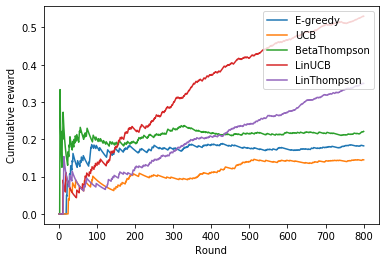

In [190]:
# the reward list to be plotted, containing the Cumulative reward per round
reward_E_greedy = []
reward_UCB = []
reward_BetaThompson = []
reward_LinUCB = []
reward_LinThompson = []

# creat model
model_E_greedy = EpsGreedy(10, 0.05)
model_UCB = UCB(10, 1.0)
model_BetaThompson = BetaThompson(10, 1.0, 1.0)
model_LinUCB = LinUCB(10, 10, 1.0)
model_LinThompson = LinThompson(10, 10, 1.0)

# test model
my_Greedy = offlineEvaluate(model_E_greedy, arms, rewards, contexts, 800)
my_UCB = offlineEvaluate(model_UCB, arms, rewards, contexts, 800)
my_BetaThompson = offlineEvaluate(model_BetaThompson, arms, rewards, contexts, 800)
my_LinUCB = offlineEvaluate(model_LinUCB, arms, rewards, contexts, 800)
my_LinThompson = offlineEvaluate(model_LinThompson, arms, rewards, contexts, 800)

# calculate the Cumulative reward
reward_each_round_E_greedy = 0.0
reward_each_round_UCB = 0.0
reward_each_round_BetaThompson = 0.0
reward_each_round_LinUCB = 0.0
reward_each_round_LinThompson = 0.0

# loop for 800 rounds
for i in range(800):
    reward_each_round_E_greedy += my_Greedy[i]
    reward_each_round_UCB += my_UCB[i]
    reward_each_round_BetaThompson += my_BetaThompson[i]
    reward_each_round_LinUCB += my_LinUCB[i]
    reward_each_round_LinThompson += my_LinThompson[i]
    
    reward_E_greedy.append(reward_each_round_E_greedy/(i+1))
    reward_UCB.append(reward_each_round_UCB/(i+1))
    reward_BetaThompson.append(reward_each_round_BetaThompson/(i+1))
    reward_LinUCB.append(reward_each_round_LinUCB/(i+1))
    reward_LinThompson.append(reward_each_round_LinThompson/(i+1))
    
T = np.linspace(1,800,800)

# plot the diagram
plt.xticks(np.linspace(0,800,9))
plt.xlabel('Round')
plt.ylabel('Cumulative reward')
plt.plot(T, reward_E_greedy, label='E-greedy')
plt.plot(T, reward_UCB, label='UCB')
plt.plot(T, reward_BetaThompson,  label='BetaThompson')
plt.plot(T, reward_LinUCB,  label='LinUCB')
plt.plot(T, reward_LinThompson, label='LinThompson')
plt.legend(loc='upper right')
plt.show

### 6.B.

In [197]:
"""Find the hyperparameter for LinUCB
   Idea:
        At the beginning :
        We split the parameters of the interval 1 from 0 to 10.
        
        Build model for each parameter and run the model
        for 800 rounds using offlineEvaluate.
        
        The get the best potential parameter with best performance.
        
        Usually the tendency for LinUCB is closer to 0, the better
        If we already got 0, then jump out.
        
        Otherwise, using the potential parameter as the middle point
        construct a new interval by expand 1 on both sides.
        Build the model and do the test again.
        
        We do this cycle for 5 times. And use the final results as the 
        best parameter in our model.
"""
mean_reward_result=[]

low = 0.0
high = 10.0

# initialise spiting the test parameter interval
my_hyperparameters = np.linspace(low,high,10)

# do 5 rounds for the entire cycle
for i in range(5):
    
    for test_parameter in my_hyperparameters:
        
        # build and test the model for 800 times
        linUCB = LinUCB(10, 10, test_parameter)
        mean_reward_result.append(np.mean(offlineEvaluate(linUCB, arms, rewards, contexts, 800)))
    
    # get the highest parameter with the best reward for this cycle 
    highest = np.argmax(mean_reward_result)
    highest_alpha = my_hyperparameters[highest]
    
    #  if the parameter >0, we do another cycle by going througn much detailed interval
    if highest > 0 :
        low = my_hyperparameters[highest -1]
        high = my_hyperparameters[highest + 1]
        final_result = np.max(mean_reward_result) 
        my_hyperparameters = np.linspace(low, high, 10)
    
    # the highest parameter == 0,then we just jump out
    # usually the tendency is closer to 0, the better
    elif highest == 0:
        final_result = np.max(mean_reward_result)
        break
    mean_reward_result=[]
        
print("The optimised alpha for LinUCB is:", highest_alpha)  
print("With the expected cumulative reward: ",final_result)

The optimised alpha for LinUCB is: 0.0
With the expected cumulative reward:  0.61625


In [198]:
""" Find the hyperparameter for LinThompson
    The idea is the same as LinUCB
"""
mean_reward_result=[]

low = 0.0
high = 10.0

# initialise spiting the test parameter interval
my_hyperparameters = np.linspace(low,high,10)

# do 5 rounds for the entire cycle
for i in range(5):
    
    for test_parameter in my_hyperparameters:
        
        # build and test the model for 800 times
        model_LinThompson = LinThompson(10, 10, test_parameter)
        mean_reward_result.append(np.mean(offlineEvaluate(model_LinThompson, arms, rewards, contexts, 800)))
    
    # get the highest parameter with the best reward for this cycle 
    highest = np.argmax(mean_reward_result)
    highest_v = my_hyperparameters[highest]
    
    #  if the parameter >0, we do another cycle by going througn much detailed interval
    if highest > 0 :
        low = my_hyperparameters[highest -1]
        high = my_hyperparameters[highest + 1]
        final_result = np.max(mean_reward_result) 
        my_hyperparameters = np.linspace(low, high, 10)
    
    # the highest parameter == 0,then we just jump out
    # usually the tendency is closer to 0, the better
    elif highest == 0:
        final_result = np.max(mean_reward_result)
        break
    
    mean_reward_result=[]
        
print("The optimised v for LinThompson is:", highest_v)  
print("With the expected cumulative reward: ",final_result)

C:\Users\xplir\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: covariance is not symmetric positive-semidefinite.


The optimised v for LinThompson is: 0.11177157953563992
With the expected cumulative reward:  0.34125
